# Jared Godar: Zillow Home Value Predictions

---

## Goal

- I will biuld and evaluate models to predict home value in order to identify over and under-valued properties.

- I will show the dirstibution of tax rates by county so we can evaluate how a given property compares others.

## Description

- The ability to accurately price a home in relation to others is essential. This allows sellers to ensure they are maximizing their profits and investors to find undervalued properties. 

- Analysis of past transactions will allow the creation of a model to accurately predict home values.

Here, I import libraries that will be used in data cleaning, analysis, visualization, modeling, and evaluation.

In [1]:
# Basic libraries
import pandas as pd
import numpy as np 

#Vizualization Tools
import matplotlib.pyplot as plt
import seaborn as sns

#Modeling Tools
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import statsmodels.api as sm

from datetime import date
from scipy import stats


## Evaluation tools
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

import warnings
warnings.filterwarnings("ignore")

#Custim functions
from env import host, user, password #Database credentials
import zillo_wrangle
import eval_model

---

## Data Wrangling

- Initial query pulls relevant data from the SQL database for 52275 homes sold in 2017.
- 56 null values in initial pull.
- Removed outliers with a cutoff of 1.5x interquartile range. (7322 records removed)
- Removed 31 remaining records with null values.
- Changed data types as appropriate.
- Added county and state from fips data.
- Added county mean home prices.
- Added column for age of home in years.
- One-hot encoded counties.
- Added tax rate columns.
- Split date into train, validate, and test sets.
- Added baseline as median home price (less sensitive to ouliers than mean).
- Split each set in to X / y feature / target sets.
- Used robust scaler to scale numeric data - fit on train and apllied to all sets.

In [2]:
# Import, clean, and split data using custom function

train, X_train, y_train, X_validate, y_validate, X_test, y_test = zillo_wrangle.wrangle()

---

## Exploratory Data Analysis

**INITIAL QUESTIONS**

1. What are factors that drive home prices?
2. What are factors that decrease home prices?
3. What features matter least?
4. Is there a significant difference in home value by county?

### Question 1: What drives home prices?

Home size has the largest impact, followed by number of bathrooms then number of bedrooms.


The p-value is: 0.000000. There is 0.0% chance that we see these results by chance.
r = 0.43


Text(0.5, 1.0, 'Figire 1: Positive correlation between area and value')

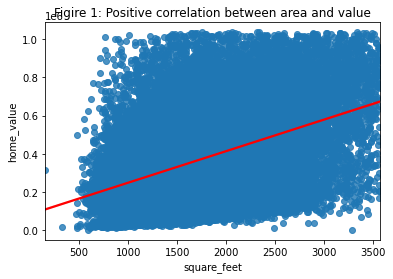

In [17]:
eval_model.correlation_exploration(train, 'square_feet', 'home_value')

plt.title('Figure 1: Positive correlation between area and value')

There is a statistically significant correlation between home area and home price

The p-value is: 0.000000. There is 0.0% chance that we see these results by chance.
r = 0.36


Text(0.5, 1.0, 'Figure 2: Positive correlation between number of bathrooms and value')

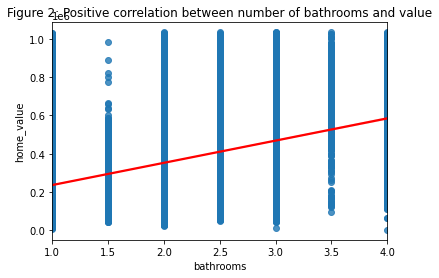

In [19]:
eval_model.correlation_exploration(train, 'bathrooms', 'home_value')

plt.title('Figure 2: Positive correlation between number of bathrooms and value')

There is a statistically significant correlation between home area and home price

The p-value is: 0.000000. There is 0.0% chance that we see these results by chance.
r = 0.19


Text(0.5, 1.0, 'Figure 3: Positive correlation between number of bedrooms  and value')

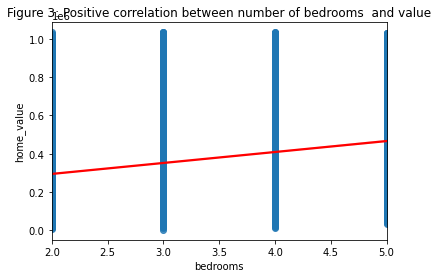

In [20]:
eval_model.correlation_exploration(train, 'bedrooms', 'home_value')

plt.title('Figure 3: Positive correlation between number of bedrooms  and value')

There is a statistically significant correlation between home area and home price

### Question 2: What factors decrease home price?

The p-value is: 0.000000. There is 0.0% chance that we see these results by chance.
r = -0.23


Text(0.5, 1.0, 'Figure 4: Negative correlation between age and value')

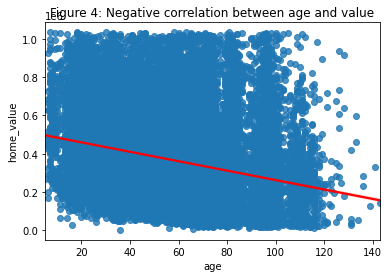

In [21]:
eval_model.correlation_exploration(train, 'age', 'home_value')

plt.title('Figure 4: Negative correlation between age and value')

There is a statistically significant correlation between home area and home price

### Question 3: Are there any factors that don't matter?

- In this initial, sparse dataset used for the MVP model, there is a statistically significant correlation between each driver and the home price.

- Number of bedrooms is least strongly correlated with home price.

### Question 4: Is there a difference in average price by county?

In [37]:
# Make a separate dataframe for each county

la = train[train.county=='Los Angeles'].home_value
oc = train[train.county=='Orange'].home_value
ven = train[train.county=='Ventura'].home_value

Text(0.5, 1.0, 'Figure 5: Average value by County')

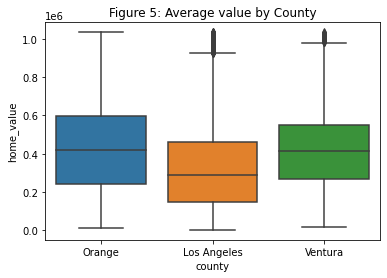

In [22]:
# Vizualize prices by county

ax = sns.boxplot(x=train.county, y=train.home_value)
#ax = sns.swarmplot(x=train.county, y=train.home_value, color ='.25')
plt.title('Figure 5: Average value by County')

- Perform Kruskal-Wallis H-test to see if there is a difference by county.

- Using a nonparametric test since the underlying distributions are not normal.

In [38]:
stats.kruskal(la, oc, ven)

KruskalResult(statistic=1357.533431618437, pvalue=1.6419533891990053e-295)

- There are differences by county. 

- Post-hoc, pairwaise analysis can determine which samples are different in which direction.

In [40]:
# Is LA lower than OC
stats.mannwhitneyu(la, oc, alternative ='less')

MannwhitneyuResult(statistic=67523869.0, pvalue=3.841782942079302e-242)

- Los Angeles County prices are lower, on average, than Orange County 

In [41]:
# Is LA lower than Ventura

stats.mannwhitneyu(la, ven, alternative ='less')

MannwhitneyuResult(statistic=21523832.5, pvalue=5.9695151055108555e-105)

- Los Angeles County prices are lower, on average, than Ventura County 

In [42]:
# Is Ventura Lower than Orange

stats.mannwhitneyu(ven, oc, alternative ='less')

MannwhitneyuResult(statistic=11424918.0, pvalue=0.11480778422845389)

Ventura is not statistically lower than orange

In [43]:
# Is there a difference between Ventura and orange

stats.mannwhitneyu(ven, oc)

MannwhitneyuResult(statistic=11424918.0, pvalue=0.11480778422845389)

In [44]:
stats.kruskal(oc, ven)

KruskalResult(statistic=1.443249323379644, pvalue=0.2296142522360047)

There is no statistically significant difference between the mean home values in Orange and Ventura Counties.

---

## Modeling